# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Thursday, March 5, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Chris Lucasius

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1AXXf1vRj0iAsqLa6mNIvhJQ_HGvBy9gB/view?usp=sharing

In [0]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [0]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [0]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [0]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [0]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [0]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [0]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [8]:
cols = ["age", "yredu", "capgain", "caploss", "workhr"]
def normalize(x, col):
  return (x[col] - x[col].min())/(x[col].max() - x[col].min())

for i in range(len(cols)):
  print(cols[i] + ' min: ' + str(df[cols[i]].min()))
  print(cols[i] + ' max: ' + str(df[cols[i]].max()))
  print(cols[i] + ' avg: ' + str(df[cols[i]].mean()))
  df[cols[i]] = normalize(df, cols[i])

df[:10]

age min: 17
age max: 90
age avg: 38.58164675532078
yredu min: 1
yredu max: 16
yredu avg: 10.0806793403151
capgain min: 0
capgain max: 99999
capgain avg: 1077.6488437087312
caploss min: 0
caploss max: 4356
caploss avg: 87.303829734959
workhr min: 1
workhr max: 99
workhr avg: 40.437455852092995


,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.301370,State-gov,77516,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.021740,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,83311,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,215646,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,234721,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,338409,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba
5,0.273973,Private,284582,Masters,0.866667,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.000000,0.0,0.397959,United-States
6,0.438356,Private,160187,9th,0.266667,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.000000,0.0,0.153061,Jamaica
7,0.479452,Self-emp-not-inc,209642,HS-grad,0.533333,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.448980,United-States
8,0.191781,Private,45781,Masters,0.866667,Never-married,Prof-specialty,Not-in-family,White,Female,0.140841,0.0,0.500000,United-States
9,0.342466,Private,159449,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.051781,0.0,0.397959,United-States


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [0]:
# hint: you can do something like this in pandas
male = sum(df["sex"] == " Male")
female = sum(df["sex"] == " Female")
percentage_female = female/(male+female)
percentage_male = male/(male+female)
print('percentage female = ' + str(percentage_female * 100) + '%')
print('percentage male = ' + str(percentage_male * 100) + '%')

percentage female = 33.07945087681583%
percentage male = 66.92054912318419%


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [0]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [0]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [11]:
print(df_with_missing.shape)
print(str(df_with_missing.shape[0]) + ' records contained missing features')
print(df_not_missing.shape)
total = df_with_missing.shape[0] + df_not_missing.shape[0]
print(str(df_with_missing.shape[0]/total * 100) + '% were removed')

(1843, 11)
1843 records contained missing features
(30718, 11)
5.660145572924664% were removed


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [0]:
work_features = df_not_missing['work'].unique()
set(work_features)

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [0]:
data = pd.get_dummies(df_not_missing)

In [0]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [0]:
print(data.shape)
'''
there are 57 columns. This puts every combination of work, married, etc.
into its own column with a 1 (true) or 0 (false) rather than using strings to
determine the value. 57 comes from work fed gov + work private + ... + sex male
+ sex female which includes the original 14 columns and the newly created columns
'''

(30718, 57)


'\nthere are 57 columns. This puts every combination of work, married, etc.\ninto its own column with a 1 (true) or 0 (false) rather than using strings to\ndetermine the value. 57 comes from work fed gov + work private + ... + sex male\n+ sex female which includes the original 14 columns and the newly created columns\n'

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [12]:
datanp = data.values.astype(np.float32)

NameError: ignored

In [0]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)
print(cat_index)
print(cat_values)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.
    # optains the index of the maximum of the split list
    return cat_values[feature][np.argmax(onehot)]

    

{'work': 5, 'marriage': 12, 'occupation': 19, 'edu': 33, 'relationship': 49, 'sex': 55}
{'work': ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 'marriage': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'occupation': ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'], 'edu': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 'sex': ['Female', 'Male']}


In [0]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [0]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
np.random.shuffle(datanp)
training, valid_and_test = datanp[:int(0.7*datanp.shape[0]), :], datanp[int(0.7*datanp.shape[0]):, :]
valid, test = valid_and_test[:int(0.5*valid_and_test.shape[0]), :], valid_and_test[int(0.5*valid_and_test.shape[0]):, :]
print(training.shape, valid.shape, test.shape)

'''
training has 21502 people, 
valid and test set has 4608 people
'''

(21502, 57) (4608, 57) (4608, 57)


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [0]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 23), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(23, 12)
        )
        self.decoder = nn.Sequential(
            nn.Linear(12, 23), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(23, 57),
            
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

In [0]:
'''
We are using the sigmoid function to obtain the percentage
of the missing feature. Since there is only one output required, 
we are using the sigmoid rather than a softmax
'''

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [0]:
import matplotlib.pyplot as plt

def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4, plot=False):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    iters = []
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    for epoch in range(num_epochs):
      for data in train_loader:
        datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
        recon = model(datam)
        loss_t = criterion(recon, data)
        loss_t.backward()
        optimizer.step()
        optimizer.zero_grad()
      for data in valid_loader:
        datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
        recon = model(datam)
        loss_v = criterion(recon, data)
      train_loss[epoch] = loss_t
      val_loss[epoch] = loss_v
      train_acc[epoch] = get_accuracy(model, train_loader)
      val_acc[epoch] = get_accuracy(model, valid_loader)
      iters.append(epoch)
    if plot == True:
      plt.title("Training Curve")
      plt.plot(iters, train_loss, label="Train loss")
      plt.plot(iters, val_loss, label="Valid loss")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.legend()
      plt.show()

      plt.title("Training Curve")
      plt.plot(iters, train_acc, label="Train")
      plt.plot(iters, val_acc, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend()
      plt.show()
    print('Most Recent Training Accuracy = ' + str(train_acc[num_epochs-1]))
    print('Most Recent Validation Accuracy = ' + str(val_acc[num_epochs-1]))
    print('Max Training Accuracy = ' + str(max(train_acc)))
    print('Max Validation Accuracy = ' + str(max(val_acc)))
    print('Most Recent Training Loss = ' + str(train_loss[num_epochs-1]))
    print('Most Recent Validation Loss = ' + str(val_loss[num_epochs-1]))
    print('Min Training Loss = ' + str(min(train_loss)))
    print('Min Validation Loss = ' + str(min(val_loss)))

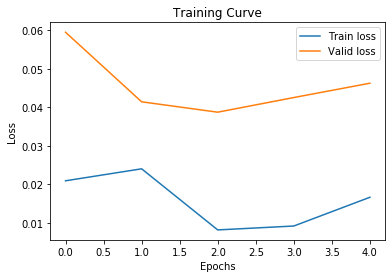

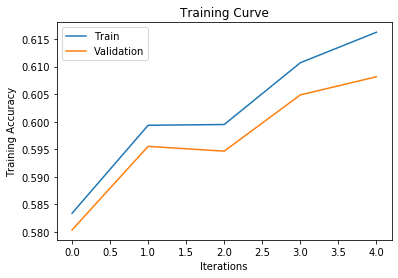

In [0]:
auto = AutoEncoder()
train_loader = torch.utils.data.DataLoader(dataset=training) 
valid_loader = torch.utils.data.DataLoader(dataset=valid)
train(auto, train_loader, valid_loader, plot=True)
'''
plots using only default values
'''

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [0]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

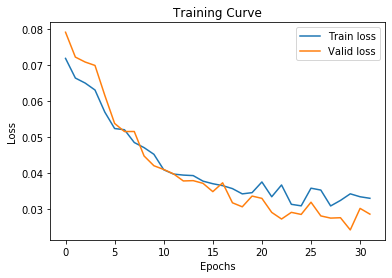

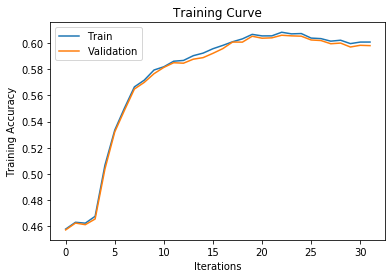

Most Recent Training Accuracy = 0.6009440982234211
Most Recent Validation Accuracy = 0.5981987847222222
Max Training Accuracy = 0.608455027439308
Max Validation Accuracy = 0.6061559606481481
Most Recent Training Loss = 0.03290458768606186
Most Recent Validation Loss = 0.028494933620095253
Min Training Loss = 0.030773820355534554
Min Validation Loss = 0.02410249598324299


In [0]:
auto = AutoEncoder()
batch=32
epochs=32
train_loader = torch.utils.data.DataLoader(dataset=training, batch_size=batch) 
valid_loader = torch.utils.data.DataLoader(dataset=valid, batch_size=batch)
train(auto, train_loader, valid_loader, num_epochs=epochs, plot=True)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

In [0]:
'''
From the previous test in part c, it seems to be converging quite quickly
so I decided to increase the batch size to slow down the convergence and 
increase accuracy. Since with larger batches, it coverges slower so I increased
the number of epochs. I am trying a different learning rate to see if there are
any changes
'''
auto = AutoEncoder()
batch=64
epochs=40
lr = 0.003
train_loader = torch.utils.data.DataLoader(dataset=training, batch_size=batch)
valid_loader = torch.utils.data.DataLoader(dataset=valid, batch_size=batch)
train(auto, train_loader, valid_loader, num_epochs=epochs, learning_rate=lr)

Most Recent Training Accuracy = 0.6458856540476855
Most Recent Validation Accuracy = 0.6435908564814815
Max Training Accuracy = 0.6471723560599014
Max Validation Accuracy = 0.6441333912037037
Most Recent Training Loss = 0.014168609865009785
Most Recent Validation Loss = 0.01432847324758768
Min Training Loss = 0.007384707219898701
Min Validation Loss = 0.007014254108071327


In [0]:
'''
From the prior test, I wanted to see if the test converged fully so I decided
to increase the number of epochs. I also decreased the learning rate to see
if I can get more accurate
'''
auto = AutoEncoder()
batch=64
epochs=45
lr = 0.0009
train_loader = torch.utils.data.DataLoader(dataset=training, batch_size=batch)
valid_loader = torch.utils.data.DataLoader(dataset=valid, batch_size=batch)
train(auto, train_loader, valid_loader, num_epochs=epochs, learning_rate=lr)

Most Recent Training Accuracy = 0.6304374786841535
Most Recent Validation Accuracy = 0.6270616319444444
Max Training Accuracy = 0.6329101168883515
Max Validation Accuracy = 0.6300636574074074
Most Recent Training Loss = 0.0132659412920475
Most Recent Validation Loss = 0.013330807909369469
Min Training Loss = 0.013193195685744286
Min Validation Loss = 0.012934567406773567


In [0]:
'''
Decreasing the learning rate did not help, so I am increasing it again leaving
it with the same number of epochs to see if it will improve accuracy
'''
auto = AutoEncoder()
batch=64
epochs=45
lr = 0.002
train_loader = torch.utils.data.DataLoader(dataset=training, batch_size=batch)
valid_loader = torch.utils.data.DataLoader(dataset=valid, batch_size=batch)
train(auto, train_loader, valid_loader, num_epochs=epochs, learning_rate=lr)

Most Recent Training Accuracy = 0.6352122283198463
Most Recent Validation Accuracy = 0.6296296296296297
Max Training Accuracy = 0.639986977955539
Max Validation Accuracy = 0.6346932870370371
Most Recent Training Loss = 0.009838264435529709
Most Recent Validation Loss = 0.011200932785868645
Min Training Loss = 0.008998074568808079
Min Validation Loss = 0.011194968596100807


In [0]:
'''
With a small learning rate, the accuracy did not converge, so I decided
to increase the number of epochs significantly to see if it would converge
with better accuracy
'''
auto = AutoEncoder()
batch=64
epochs=69
lr = 0.002
train_loader = torch.utils.data.DataLoader(dataset=training, batch_size=batch)
valid_loader = torch.utils.data.DataLoader(dataset=valid, batch_size=batch)
train(auto, train_loader, valid_loader, num_epochs=epochs, learning_rate=lr)

Most Recent Training Accuracy = 0.6575589867609215
Most Recent Validation Accuracy = 0.6536096643518519
Max Training Accuracy = 0.6638839797848263
Max Validation Accuracy = 0.6574435763888888
Most Recent Training Loss = 0.012847565114498138
Most Recent Validation Loss = 0.016070641577243805
Min Training Loss = 0.008062788285315037
Min Validation Loss = 0.0062999785877764225


## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [0]:
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch)
test_acc = get_accuracy(auto, test_loader)
print('test accuracy is ' + str(test_acc * 100))

'''
test accuracy is about 65%
'''

test accuracy is 65.40798611111111


'\ntest accuracy is about 65%\n'

### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [16]:
all_column_values = ['age',	'yredu', 'capgain', 'caploss', 'workhr', 'work', 'marriage', 'occupation', 'edu', 'relationship', 'sex']
most_common = []
count_common = []
for i in range(len(all_column_values)):
  most_common.append(df_not_missing[all_column_values[i]].value_counts().idxmax())
print(most_common)
for i in range(len(all_column_values)):
  count_most_common = df_not_missing[(df_not_missing[all_column_values[i]]==most_common[i])].count()
  count_common.append(int(count_most_common['age'])/df_not_missing.shape[0])
percentage = sum(count_common)/len(count_common)
print('Baseline Accuracy = ' + str(percentage*100) + '%')

'''
Test Accuracy of the baseline is roughly 49.54%
'''

[0.2602739726027397, 0.5333333333333333, 0.0, 0.0, 0.3979591836734694, ' Private', ' Married-civ-spouse', ' Prof-specialty', ' HS-grad', ' Husband', ' Male']
Baseline Accuracy = 49.538322215579846%


'\nTest Accuracy of the baseline is roughly 49.54%\n'

### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

In [0]:
'''
From part b, my test accuracy was 65.4% and from above, the baseline accuracy
is 49.5%. The autoencoder is slightly better but both are fairly low and close
to eachother since it is difficult to predict features of someone without any 
pattern
'''

'\nFrom part b, my test accuracy was 65.4% and from above, the baseline accuracy\nis 49.5%. The autoencoder is slightly better but both are fairly low and close\nto eachother since it is difficult to predict features of someone without any \npattern\n'

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [0]:
arr = test[0]
col_names = ['work', 'marriage', 'occupation', 'edu', 'relationship', 'sex']
count = 0
for i in range(5, len(arr)):
  if arr[i] == 1:
    print(col_names[count], cat_values[col_names[count]][i - cat_index[col_names[count]]])
    count+=1
'''
I do not think it is reasonable for a human to be able to guess a person's 
education level from their other features. I would have guessed that this person
would have at least an education level of masters since his occupation is in
prof-specialty. But he only has a bachelors degree. 

It is difficult for people to guess a person education based on certain traits
and if we were to guess, we will most likely be incorrect.
'''

work Private
marriage Divorced
occupation Prof-specialty
edu Bachelors
relationship Not-in-family
sex Male


'\nno, education is bachelors\n'

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [0]:
test_first = test[0]
test_first = torch.from_numpy(test_first)
# data_test_first = torch.utils.data.DataLoader(dataset=test_first)
# for data in data_test_first:
tensor_res = auto(test_first)
res = tensor_res.tolist()
edu_result = res[cat_index['edu']:cat_index['edu']+len(cat_values['edu'])]
edu_index = edu_result.index(max(edu_result))
print(cat_values['edu'][edu_index])
'''
Bachelors
'''

Bachelors


'\n\n'

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [0]:
print(most_common[8])
'''
Highschool graduate
'''

 HS-grad


'\nHighschool grad\n'